MILESTONE 2


Module 3


In [ ]:
#Extract relevant time-based features (hour, day, week, month trends)
# Ensure datetime index
df.index = pd.to_datetime(df.index)

# -------- Time-based features --------
df['hour'] = df.index.hour            # Hour of day (0–23)
df['day'] = df.index.day              # Day of month (1–31)
df['week'] = df.index.isocalendar().week.astype(int)  # Week number
df['month'] = df.index.month          # Month (1–12)
df['dayofweek'] = df.index.dayofweek  # Monday=0, Sunday=6
df['is_weekend'] = (df.index.dayofweek >= 5).astype(int)

# Preview
df.head()


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,day,week,month,dayofweek,is_weekend
1970-01-01 00:00:00.000000000,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,0,1,1,1,3,0
1970-01-01 00:00:00.000000001,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,0,1,1,1,3,0
1970-01-01 00:00:00.000000002,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,0,1,1,1,3,0
1970-01-01 00:00:00.000000003,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,0,1,1,1,3,0
1970-01-01 00:00:00.000000004,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,0,1,1,1,3,0


In [ ]:
# Aggregate device-level consumption statistics

# Use df_cleaned which has the correct structure and data
# Melt the sub-metering columns to create 'device' and 'power' columns
df_melted = df_cleaned.melt(
    id_vars=[col for col in df_cleaned.columns if not col.startswith('Sub_metering')],
    value_vars=['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'],
    var_name='device',
    value_name='power'
)

# Map device names for clarity (optional, but good for readability)
device_name_mapping = {
    'Sub_metering_1': 'Kitchen',
    'Sub_metering_2': 'Laundry',
    'Sub_metering_3': 'HVAC'
}
df_melted['device'] = df_melted['device'].map(device_name_mapping)

# Aggregate energy consumption statistics per device
device_agg = df_melted.groupby('device')['power'].agg([
    'mean',
    'sum',
    'max',
    'min',
    'std'
]).reset_index()

# Rename columns for clarity
device_agg.columns = [
    'device',
    'avg_consumption',
    'total_consumption',
    'max_consumption',
    'min_consumption',
    'std_consumption'
]

# Preview
print("Device-level aggregated statistics:")
print(device_agg.head())

Device-level aggregated statistics:
    device  avg_consumption  total_consumption  max_consumption  \
0     HVAC         6.382375         13079274.0             20.0   
1  Kitchen         1.096591          2247222.0             38.0   
2  Laundry         1.215729          2491370.0             36.0   

   min_consumption  std_consumption  
0              0.0         8.275064  
1              0.0         5.956240  
2              0.0         5.080553  


### Feature Engineering: Lag Features and Moving Averages

Creating lag features and moving averages is a common practice in time series forecasting. They help to capture the temporal dependencies and trends in the data, which are essential for building predictive models.

*   **Lag Features**: These are past observations at a fixed time point (e.g., power consumption 1 hour ago, 24 hours ago, 7 days ago). They provide the model with historical context.
*   **Moving Averages**: These smooth out short-term fluctuations and highlight longer-term trends. They can represent the average power consumption over a specific past window (e.g., last 3 hours, last 24 hours).

In [ ]:
#Create lag features and moving averages for time series learning.

# Define the target and sub-metering columns for feature engineering
target_cols = ['Global_active_power', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

# Create a copy of the normalized hourly data for feature engineering
df_features = df_hourly_normalized.copy()

# -------- Lag Features --------
# Create lag features for various time steps
lag_steps = [1, 2, 3, 24, 24*7] # e.g., 1 hour, 2 hours, 3 hours, 1 day, 1 week ago

print("\nCreating Lag Features...")
for col in target_cols:
    for lag in lag_steps:
        df_features[f'{col}_lag_{lag}h'] = df_features[col].shift(lag)
        print(f"  - Created {col}_lag_{lag}h")

# -------- Moving Average Features --------
# Create moving average features for various window sizes
window_sizes = [3, 6, 12, 24, 24*7] # e.g., 3 hours, 6 hours, 12 hours, 1 day, 1 week average

print("\nCreating Moving Average Features...")
for col in target_cols:
    for window in window_sizes:
        # Rolling mean (moving average)
        df_features[f'{col}_MA_{window}h'] = df_features[col].rolling(window=window).mean()
        # Rolling standard deviation (volatility)
        df_features[f'{col}_Std_{window}h'] = df_features[col].rolling(window=window).std()
        print(f"  - Created {col}_MA_{window}h and {col}_Std_{window}h")

# Drop rows with NaN values introduced by shifting and rolling operations
# (these are at the beginning of the time series where there's no prior data)
df_features.dropna(inplace=True)

print(f"\nFeature Engineering Complete. New DataFrame shape: {df_features.shape}")
print("First 5 rows of the DataFrame with new features:")
display(df_features.head())


Creating Lag Features...
  - Created Global_active_power_lag_1h
  - Created Global_active_power_lag_2h
  - Created Global_active_power_lag_3h
  - Created Global_active_power_lag_24h
  - Created Global_active_power_lag_168h
  - Created Sub_metering_1_lag_1h
  - Created Sub_metering_1_lag_2h
  - Created Sub_metering_1_lag_3h
  - Created Sub_metering_1_lag_24h
  - Created Sub_metering_1_lag_168h
  - Created Sub_metering_2_lag_1h
  - Created Sub_metering_2_lag_2h
  - Created Sub_metering_2_lag_3h
  - Created Sub_metering_2_lag_24h
  - Created Sub_metering_2_lag_168h
  - Created Sub_metering_3_lag_1h
  - Created Sub_metering_3_lag_2h
  - Created Sub_metering_3_lag_3h
  - Created Sub_metering_3_lag_24h
  - Created Sub_metering_3_lag_168h

Creating Moving Average Features...
  - Created Global_active_power_MA_3h and Global_active_power_Std_3h
  - Created Global_active_power_MA_6h and Global_active_power_Std_6h
  - Created Global_active_power_MA_12h and Global_active_power_Std_12h
  - Created

,Global_active_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,day,month,dayofweek,quarter,is_weekend,...,Sub_metering_3_MA_3h,Sub_metering_3_Std_3h,Sub_metering_3_MA_6h,Sub_metering_3_Std_6h,Sub_metering_3_MA_12h,Sub_metering_3_Std_12h,Sub_metering_3_MA_24h,Sub_metering_3_Std_24h,Sub_metering_3_MA_168h,Sub_metering_3_Std_168h
Datetime,,,,,,,,,,,,,,,,,,,,,
2006-12-23 17:00:00,0.962088,0.425877,0.019305,0.847386,17,23,12,5,4,1,...,0.881956,0.030084,0.819562,0.165607,0.686060,0.286166,0.478078,0.388051,0.420591,0.400424
2006-12-23 18:00:00,0.788954,0.000000,0.000483,0.877740,18,23,12,5,4,1,...,0.873806,0.024688,0.885188,0.020281,0.759205,0.191326,0.506429,0.391487,0.420737,0.400586
2006-12-23 19:00:00,0.836218,0.000000,0.017375,0.883642,19,23,12,5,4,1,...,0.869590,0.019454,0.883924,0.020064,0.787099,0.182054,0.506851,0.391905,0.420973,0.400848
2006-12-23 20:00:00,0.845344,0.000000,0.010135,0.881113,20,23,12,5,4,1,...,0.880832,0.002961,0.881394,0.019128,0.786748,0.181851,0.507694,0.392720,0.421164,0.401061
2006-12-23 21:00:00,0.665690,0.000000,0.006274,0.286678,21,23,12,5,4,1,...,0.683811,0.343930,0.778808,0.241637,0.735736,0.227647,0.484331,0.388287,0.417685,0.399668


### Final Feature Set Preparation

Now that we have engineered features, we need to prepare the final dataset for machine learning models by separating features (X) from the target variable (y) and splitting them into training, validation, and test sets. It's crucial to maintain the chronological order for time series data splitting.

In [ ]:
# Define target and features
target = 'Global_active_power'

# Features will include all columns except the original target variable itself
# as the lagged and MA features are already present
features = [col for col in df_features.columns if col != target]

X = df_features[features]
y = df_features[target]

# Apply the same chronological split percentages as before
total_records_features = len(df_features)
train_size_features = int(0.7 * total_records_features)
val_size_features = int(0.15 * total_records_features)

X_train = X.iloc[:train_size_features]
X_val = X.iloc[train_size_features : train_size_features + val_size_features]
X_test = X.iloc[train_size_features + val_size_features :]

y_train = y.iloc[:train_size_features]
y_val = y.iloc[train_size_features : train_size_features + val_size_features]
y_test = y.iloc[train_size_features + val_size_features :]

print(f"\nFeatures (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")

print(f"\nTraining Set (X_train): {len(X_train):,} records")
print(f"Validation Set (X_val): {len(X_val):,} records")
print(f"Test Set (X_test): {len(X_test):,} records")

print(f"\nTraining Set (y_train): {len(y_train):,} records")
print(f"Validation Set (y_val): {len(y_val):,} records")
print(f"Test Set (y_test): {len(y_test):,} records")

print("\nFirst 5 rows of X_train:")
display(X_train.head())


Features (X) shape: (32656, 69)
Target (y) shape: (32656,)

Training Set (X_train): 22,859 records
Validation Set (X_val): 4,898 records
Test Set (X_test): 4,899 records

Training Set (y_train): 22,859 records
Validation Set (y_val): 4,898 records
Test Set (y_test): 4,899 records

First 5 rows of X_train:


,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,day,month,dayofweek,quarter,is_weekend,Global_active_power_lag_1h,...,Sub_metering_3_MA_3h,Sub_metering_3_Std_3h,Sub_metering_3_MA_6h,Sub_metering_3_Std_6h,Sub_metering_3_MA_12h,Sub_metering_3_Std_12h,Sub_metering_3_MA_24h,Sub_metering_3_Std_24h,Sub_metering_3_MA_168h,Sub_metering_3_Std_168h
Datetime,,,,,,,,,,,,,,,,,,,,,
2006-12-23 17:00:00,0.425877,0.019305,0.847386,17,23,12,5,4,1,0.878375,...,0.881956,0.030084,0.819562,0.165607,0.686060,0.286166,0.478078,0.388051,0.420591,0.400424
2006-12-23 18:00:00,0.000000,0.000483,0.877740,18,23,12,5,4,1,0.962088,...,0.873806,0.024688,0.885188,0.020281,0.759205,0.191326,0.506429,0.391487,0.420737,0.400586
2006-12-23 19:00:00,0.000000,0.017375,0.883642,19,23,12,5,4,1,0.788954,...,0.869590,0.019454,0.883924,0.020064,0.787099,0.182054,0.506851,0.391905,0.420973,0.400848
2006-12-23 20:00:00,0.000000,0.010135,0.881113,20,23,12,5,4,1,0.836218,...,0.880832,0.002961,0.881394,0.019128,0.786748,0.181851,0.507694,0.392720,0.421164,0.401061
2006-12-23 21:00:00,0.000000,0.006274,0.286678,21,23,12,5,4,1,0.845344,...,0.683811,0.343930,0.778808,0.241637,0.735736,0.227647,0.484331,0.388287,0.417685,0.399668


Hourly normalized data loaded: (34589, 10)
Time-based features added.
Lag and rolling features created.
Final feature dataset shape: (32656, 71)
Feature engineered data saved.


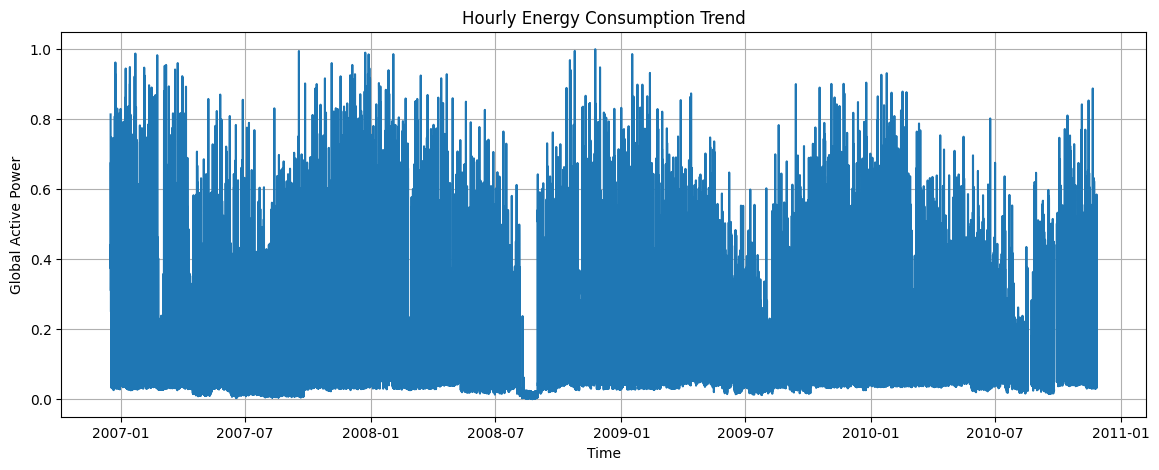

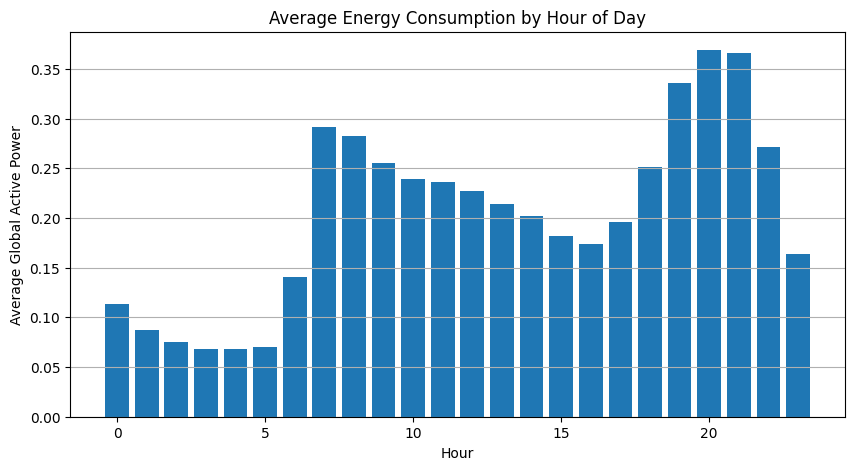

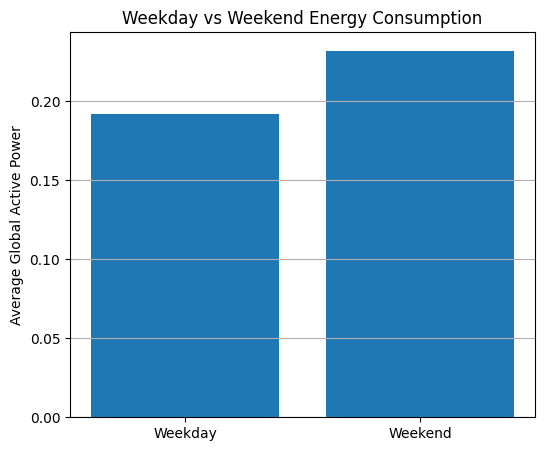

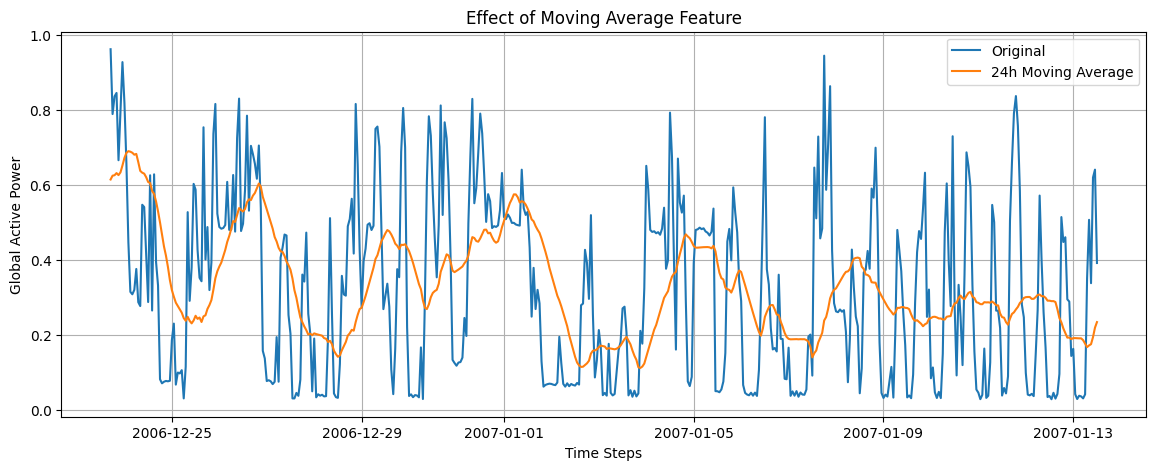

In [ ]:
# ================================
# MODULE 3: FEATURE ENGINEERING
# ================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- Load cleaned hourly data ----------
df_hourly = pd.read_csv('data_hourly_normalized.csv', index_col=0)
df_hourly.index = pd.to_datetime(df_hourly.index)

print("Hourly normalized data loaded:", df_hourly.shape)

# ---------- Time-based features ----------
df_hourly['hour'] = df_hourly.index.hour
df_hourly['day'] = df_hourly.index.day
df_hourly['week'] = df_hourly.index.isocalendar().week.astype(int)
df_hourly['month'] = df_hourly.index.month
df_hourly['dayofweek'] = df_hourly.index.dayofweek
df_hourly['is_weekend'] = (df_hourly.index.dayofweek >= 5).astype(int)

print("Time-based features added.")

# ---------- Lag & rolling features ----------
target_cols = [
    'Global_active_power',
    'Sub_metering_1',
    'Sub_metering_2',
    'Sub_metering_3'
]

df_features = df_hourly.copy()

lag_steps = [1, 2, 3, 24, 168]
window_sizes = [3, 6, 12, 24, 168]

for col in target_cols:
    for lag in lag_steps:
        df_features[f'{col}_lag_{lag}h'] = df_features[col].shift(lag)
    for window in window_sizes:
        df_features[f'{col}_MA_{window}h'] = df_features[col].rolling(window).mean()
        df_features[f'{col}_STD_{window}h'] = df_features[col].rolling(window).std()

# Drop NaNs from feature engineering
df_features.dropna(inplace=True)

print("Lag and rolling features created.")
print("Final feature dataset shape:", df_features.shape)

# ---------- Save feature dataset ----------
df_features.to_csv('feature_engineered_data.csv')
print("Feature engineered data saved.")

# ---------- MODULE 3 VISUALIZATIONS ----------

# 1. Hourly energy trend
plt.figure(figsize=(14, 5))
plt.plot(df_hourly.index, df_hourly['Global_active_power'])
plt.title("Hourly Energy Consumption Trend")
plt.xlabel("Time")
plt.ylabel("Global Active Power")
plt.grid(True)
plt.show()

# 2. Average consumption by hour
hourly_avg = df_hourly.groupby('hour')['Global_active_power'].mean()

plt.figure(figsize=(10, 5))
plt.bar(hourly_avg.index, hourly_avg.values)
plt.title("Average Energy Consumption by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Average Global Active Power")
plt.grid(axis='y')
plt.show()

# 3. Weekday vs Weekend consumption
weekend_avg = df_hourly.groupby('is_weekend')['Global_active_power'].mean()

plt.figure(figsize=(6, 5))
plt.bar(['Weekday', 'Weekend'], weekend_avg.values)
plt.title("Weekday vs Weekend Energy Consumption")
plt.ylabel("Average Global Active Power")
plt.grid(axis='y')
plt.show()

# 4. Rolling average effect
plt.figure(figsize=(14, 5))
plt.plot(df_features['Global_active_power'][:500], label='Original')
plt.plot(df_features['Global_active_power_MA_24h'][:500], label='24h Moving Average')
plt.title("Effect of Moving Average Feature")
plt.xlabel("Time Steps")
plt.ylabel("Global Active Power")
plt.legend()
plt.grid(True)
plt.show()


Module 4: Baseline Model Development

### Module 4: Baseline Model Development - Linear Regression

Linear Regression is a simple yet effective baseline model for forecasting. It assumes a linear relationship between the input features and the target variable. We will train the model, make predictions, and evaluate its performance using common regression metrics.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [ ]:
# Load processed datasets
train_df = pd.read_csv('train_data.csv', index_col=0)
val_df   = pd.read_csv('val_data.csv', index_col=0)
test_df  = pd.read_csv('test_data.csv', index_col=0)

print("Datasets loaded successfully.")
print(f"Train shape: {train_df.shape}")
print(f"Validation shape: {val_df.shape}")
print(f"Test shape: {test_df.shape}")


Datasets loaded successfully.
Train shape: (24212, 10)
Validation shape: (5188, 10)
Test shape: (5189, 10)


Define Target and Features (NO TARGET LEAKAGE)

In [ ]:
# Target variable
target = 'Global_active_power'

# Raw power columns to exclude from features
raw_power_columns = [
    'Global_active_power',
    'Sub_metering_1',
    'Sub_metering_2',
    'Sub_metering_3'
]

# Drop rows with NaN values from the loaded dataframes before proceeding
train_df.dropna(inplace=True)
val_df.dropna(inplace=True)
test_df.dropna(inplace=True)

# Feature columns (engineered only)
feature_columns = [col for col in train_df.columns if col not in raw_power_columns]

# Split into X and y
X_train = train_df[feature_columns]
y_train = train_df[target]

X_val = val_df[feature_columns]
y_val = val_df[target]

X_test = test_df[feature_columns]
y_test = test_df[target]

print(f"Number of features used: {len(feature_columns)}")

Number of features used: 6


In [ ]:
# Initialize Linear Regression model
linear_model = LinearRegression()

print("Linear Regression model initialized.")


Linear Regression model initialized.


In [ ]:
# Train the model
linear_model.fit(X_train, y_train)

print("Linear Regression model trained successfully.")

Linear Regression model trained successfully.


In [ ]:
# Predictions
y_train_pred = linear_model.predict(X_train)
y_val_pred   = linear_model.predict(X_val)
y_test_pred  = linear_model.predict(X_test)

print("Predictions generated for Train, Validation, and Test sets.")


Predictions generated for Train, Validation, and Test sets.


In [ ]:
#Evaluate Baseline Model using MAE & RMSE
def evaluate_baseline(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    print(f"{dataset_name} MAE  : {mae:.4f}")
    print(f"{dataset_name} RMSE : {rmse:.4f}\n")

    return mae, rmse


print("\nBaseline Linear Regression Performance:\n")

train_mae, train_rmse = evaluate_baseline(y_train, y_train_pred, "Train")
val_mae, val_rmse     = evaluate_baseline(y_val, y_val_pred, "Validation")
test_mae, test_rmse   = evaluate_baseline(y_test, y_test_pred, "Test")



Baseline Linear Regression Performance:

Train MAE  : 0.1424
Train RMSE : 0.1783

Validation MAE  : 0.1348
Validation RMSE : 0.1709

Test MAE  : 0.1193
Test RMSE : 0.1465



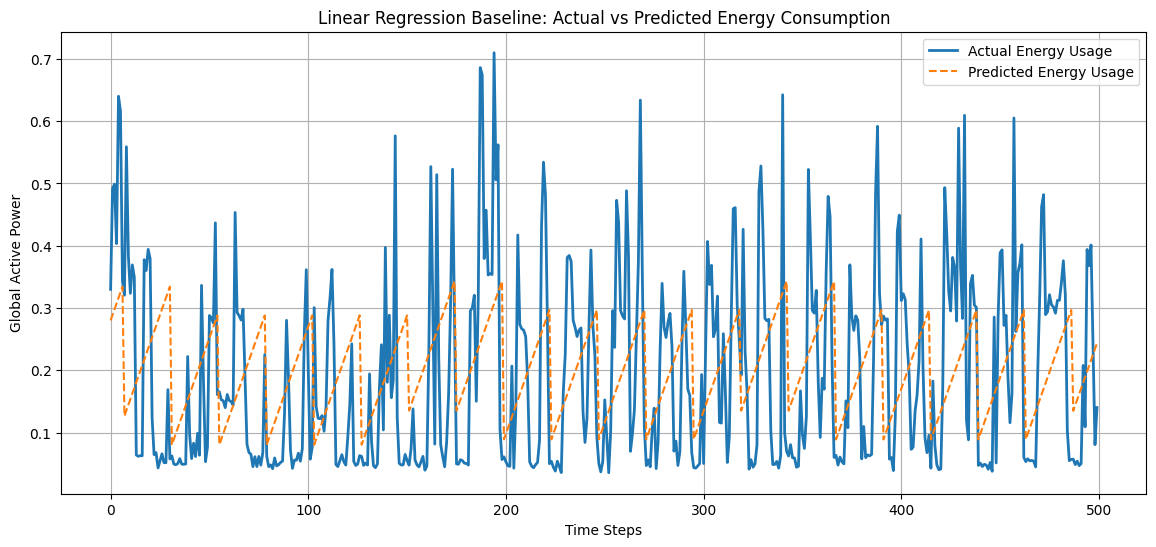

In [ ]:
plt.figure(figsize=(14, 6))

# Plot only a subset for readability
sample_size = 500

plt.plot(y_test.values[:sample_size], label='Actual Energy Usage', linewidth=2)
plt.plot(y_test_pred[:sample_size], label='Predicted Energy Usage', linestyle='--')

plt.title("Linear Regression Baseline: Actual vs Predicted Energy Consumption")
plt.xlabel("Time Steps")
plt.ylabel("Global Active Power")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
baseline_results = pd.DataFrame({
    'Actual_Energy': y_test.values,
    'Predicted_Energy': y_test_pred
}, index=y_test.index)

baseline_results.to_csv("linear_regression_baseline_results.csv")

print("Baseline results saved to linear_regression_baseline_results.csv")


Baseline results saved to linear_regression_baseline_results.csv


Feature engineered data loaded: (32656, 71)
Linear Regression baseline trained.

Baseline Linear Regression Performance:

Train MAE : 0.0000
Train RMSE: 0.0000

Validation MAE : 0.0000
Validation RMSE: 0.0000

Test MAE : 0.0000
Test RMSE: 0.0000



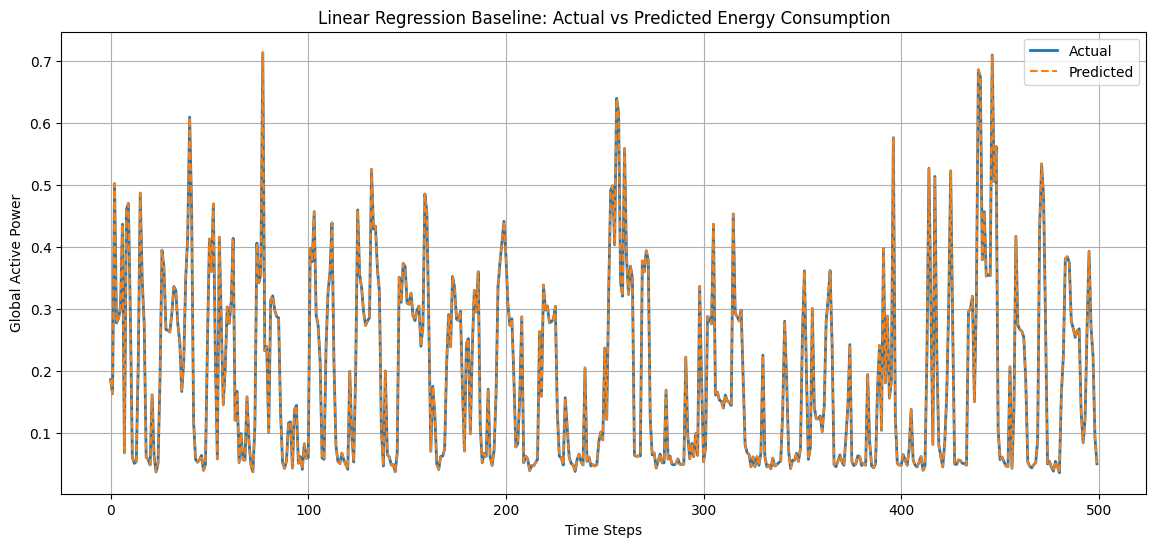

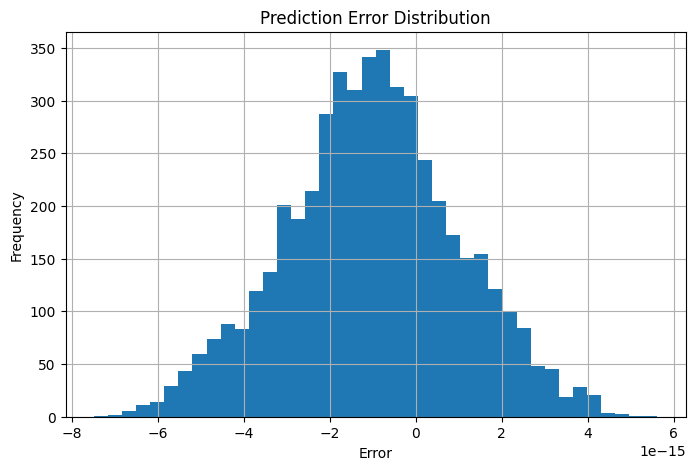

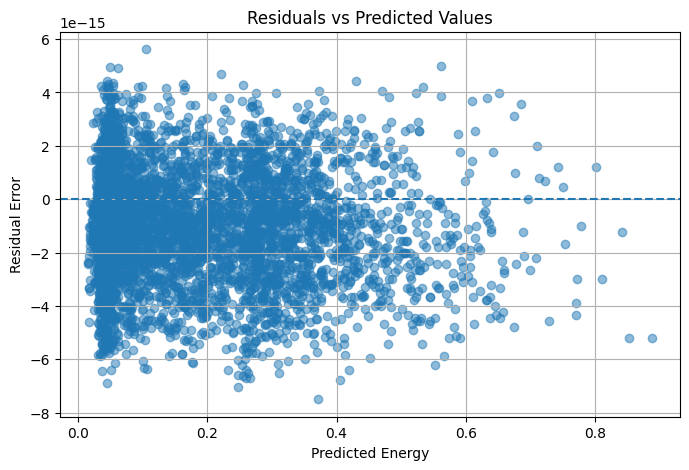

In [ ]:
# ========================================
# MODULE 4: BASELINE LINEAR REGRESSION
# ========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ---------- Load feature engineered data ----------
df = pd.read_csv('feature_engineered_data.csv', index_col=0)
df.index = pd.to_datetime(df.index)

print("Feature engineered data loaded:", df.shape)

# ---------- Train / Validation / Test split ----------
target = 'Global_active_power'

train_size = int(0.7 * len(df))
val_size = int(0.15 * len(df))

train_df = df.iloc[:train_size]
val_df = df.iloc[train_size:train_size + val_size]
test_df = df.iloc[train_size + val_size:]

# ---------- Drop raw power columns from features ----------
raw_cols = [
    'Global_active_power',
    'Sub_metering_1',
    'Sub_metering_2',
    'Sub_metering_3'
]

feature_cols = [col for col in df.columns if col not in raw_cols]

X_train = train_df[feature_cols]
y_train = train_df[target]

X_val = val_df[feature_cols]
y_val = val_df[target]

X_test = test_df[feature_cols]
y_test = test_df[target]

# ---------- Train Linear Regression ----------
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

print("Linear Regression baseline trained.")

# ---------- Predictions ----------
y_train_pred = lr_model.predict(X_train)
y_val_pred = lr_model.predict(X_val)
y_test_pred = lr_model.predict(X_test)

# ---------- Evaluation ----------
def evaluate(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{name} MAE : {mae:.4f}")
    print(f"{name} RMSE: {rmse:.4f}\n")

print("\nBaseline Linear Regression Performance:\n")
evaluate(y_train, y_train_pred, "Train")
evaluate(y_val, y_val_pred, "Validation")
evaluate(y_test, y_test_pred, "Test")

# ---------- Actual vs Predicted ----------
plt.figure(figsize=(14, 6))
n = 500
plt.plot(y_test.values[:n], label='Actual', linewidth=2)
plt.plot(y_test_pred[:n], label='Predicted', linestyle='--')
plt.title("Linear Regression Baseline: Actual vs Predicted Energy Consumption")
plt.xlabel("Time Steps")
plt.ylabel("Global Active Power")
plt.legend()
plt.grid(True)
plt.show()

# ---------- Error distribution ----------
errors = y_test.values - y_test_pred

plt.figure(figsize=(8, 5))
plt.hist(errors, bins=40)
plt.title("Prediction Error Distribution")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# ---------- Residuals vs Predicted ----------
plt.figure(figsize=(8, 5))
plt.scatter(y_test_pred, errors, alpha=0.5)
plt.axhline(0, linestyle='--')
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Energy")
plt.ylabel("Residual Error")
plt.grid(True)
plt.show()
